In [1]:
"""
Code to produce the saliency plots in section 5.1 of the paper 
Boltzmann Convolutions and Welford mean-variance layers with an application to 
time series forecasting and classification
"""

'\nCode to produce the saliency plots in section 5.1 of the paper \nBoltzmann Convolutions and Welford mean-variance layers with an application to \ntime series forecasting and classification\n'

In [2]:
#Import packages to facillitate this research 
import numpy as np 
import tensorflow as tf #(https://www.tensorflow.org/install)
from tensorflow.keras import (layers,Model) 
from tensorflow.keras.layers import (Layer, Input, Dense, Concatenate, Activation, TimeDistributed,
Flatten, Lambda, GlobalAveragePooling1D, LeakyReLU) 
from tensorflow.keras.utils import to_categorical 
from concretedropout.tensorflow import (ConcreteDenseDropout, ConcreteSpatialDropout1D, # https://github.com/aurelio-amerio/ConcreteDropout
get_weight_regularizer, get_dropout_regularizer) 
from sktime.classification.deep_learning import InceptionTimeClassifier #https://www.sktime.net/en/stable/get_started.html
from aeon.classification.convolution_based import MultiRocketHydraClassifier #https://www.aeon-toolkit.org/en/stable/installation.html
from aeon.classification.early_classification import TEASER
from aeon.classification.hybrid import HIVECOTEV2
from aeon.datasets import load_classification 
from sklearn.metrics import (accuracy_score, mean_absolute_error, mean_squared_error,  # https://scikit-learn.org/stable/install.html
classification_report)
from sklearn.model_selection import train_test_split
from math import comb
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import SMOTE

/opt/anaconda3/lib/python3.12/site-packages/aeon/base/__init__.py:24: FutureWarning: The aeon package will soon be releasing v1.0.0 with the removal of legacy modules and interfaces such as BaseTransformer and BaseForecaster. This will contain breaking changes. See aeon-toolkit.org for more information. Set aeon.AEON_DEPRECATION_WARNING or the AEON_DEPRECATION_WARNING environmental variable to 'False' to disable this warning.
  warnings.warn(


In [3]:
X, y = load_classification("ECG5000")  
X = X.reshape(X.shape[0], -1) 
y = y.astype(int) 
y = y-1 
print(Counter(y))
smote = SMOTE(random_state=42) 
X_resampled, y_resampled = smote.fit_resample(X, y)
print(Counter(y_resampled))
print(X_resampled.shape)
print(y_resampled.shape)
X = X_resampled 
y = y_resampled
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
def create_forecast_data(data, n_forecast): 
    X_forecast = []
    for series in data:
        if len(series) > n_forecast:
            X_forecast.append(series[:-n_forecast])  
    return np.array(X_forecast)  
n_forecast = 5 
X_observed_train = create_forecast_data(X_train, n_forecast) 
X_observed_train = X_observed_train.astype(np.float32) 
X_forecast_train = np.array([series[-n_forecast:] for series in X_train if len(series) > n_forecast]) 
X_forecast_train = X_forecast_train.astype(np.float32)
X_observed_test  = create_forecast_data(X_test, n_forecast) 
X_observed_test = X_observed_test.astype(np.float32)  
X_forecast_test = np.array([series[-n_forecast:] for series in X_test if len(series)>n_forecast]) 
X_forecast_test = X_forecast_test.astype(np.float32)
n_classes = len(np.unique(y_train)) 
y_train = to_categorical(y_train, num_classes = n_classes) 
y_test = to_categorical(y_test, num_classes = n_classes) 
X_observed_train = np.expand_dims(X_observed_train, axis = -1) 
X_observed_test = np.expand_dims(X_observed_test, axis = -1) 
X_train = np.expand_dims(X_train, axis = -1)
X_test = np.expand_dims(X_test, axis = -1)

Counter({0: 2919, 1: 1767, 3: 194, 2: 96, 4: 24})
Counter({0: 2919, 1: 2919, 2: 2919, 3: 2919, 4: 2919})
(14595, 140)
(14595,)


In [4]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(X_observed_train.shape)
print(X_observed_test.shape)
print(X_forecast_train.shape)
print(X_forecast_test.shape)

(11676, 140, 1)
(2919, 140, 1)
(11676, 5)
(2919, 5)
(11676, 135, 1)
(2919, 135, 1)
(11676, 5)
(2919, 5)


In [5]:
Ns = X_observed_train.shape[0]
time_steps = X_observed_train.shape[1]
n_forecast = X_forecast_train.shape[1]
n_classes = y_train.shape[1]
wr = get_weight_regularizer(Ns, l=1e-2, tau=0.5) #Determines the amount of regularization on the weights in the concrete dropout layers of ForeClassNet
dr = get_dropout_regularizer(Ns, tau=0.5, cross_entropy_loss=True) #Determines the amount of regularization on the dropout probabilities of ForeClassNet

In [6]:
def create_custom_filters(filter_length):
    """
    Function that takes in a user specified filter length to then construct hand-crafted filters 
    according to (8)-(10) in section 3.2 of the research paper. 
    """
    filter_1 = np.array([(-1) ** (i + 1) for i in range(filter_length)], dtype=np.float32).reshape(filter_length, 1, 1) #decreasing filter
    filter_2 = np.array([(-1) ** i for i in range(filter_length)], dtype=np.float32).reshape(filter_length, 1, 1) #increasing filter
    filter_3 = np.zeros(filter_length) #peaks filter 
    for n in range(0, int(((filter_length - 3) / 3) + 1)): #see section 3.2 for discussion of the formulas
        filter_3[n] = (-3 / filter_length) * comb(int((filter_length - 3) / 3), n)
    for n in range(int(filter_length / 3), int((2 * (filter_length - 3) / 3) + 2)):
        filter_3[n] = (6 / filter_length) * comb(int((filter_length - 3) / 3), int(n - (filter_length / 3)))
    for n in range(int((2 * (filter_length - 3) / 3) + 2), filter_length):
        filter_3[n] = (-3 / filter_length) * comb(int((filter_length - 3) / 3), int(n - (2 * (filter_length - 3) / 3) - 2))
    filter_3 = filter_3.reshape(filter_length, 1, 1)
    custom_filters = np.concatenate([filter_1, filter_2, filter_3], axis=2) #combine the filters together
    return custom_filters
class WelfordMeanVarianceLayer(Layer): #Defining the Welford Mean-variance layer (section 2.2) as a subclass of Layer in Keras 
    def __init__(self, total_series, n_forecast=4, **kwargs): #constructor of the class, where it takes in the number of time series we want to have mean and variance estimates for and the number of forecasts for each 
        super(WelfordMeanVarianceLayer, self).__init__(**kwargs) #calls the Keras layer class
        self.total_series = total_series #number of series the layer will track 
        self.n_forecast = n_forecast #number of forecast steps ahead 
        self.stats = self.add_weight( #creates a non-trainable tensor to store the means and variances which is initialized with zeros
            shape=(self.total_series, self.n_forecast, 2),
            initializer="zeros",
            trainable=False,
            name="stats"
        ) 
        self.count = self.add_weight( #creates a non-trainable tensor to count how many samples for the mean and variance we have for the forecasts of a given time series, which are obtained through successive forward passes
            shape=(self.total_series,),
            initializer="zeros",
            trainable=False,
            name="count"
        )
    def reset_statistics(self): #A method to clear the existing estimates of the mean and variance of the forecasts and set them to zero, which you might want to do during testing
        self.stats.assign(tf.zeros_like(self.stats))
        self.count.assign(tf.zeros_like(self.count))
    def call(self, inputs, **kwargs): #main method used when calling the Welford layer in a given forward pass
        forecast_values, series_ids = inputs  #unpacks the inputs into the Welford layer, the forecast values in the current forward pass and the ids of the current time series being processed. 
        batch_size = tf.shape(forecast_values)[0] #derives the current batch size from the shape of the forecast values tensor
        def loop_body(i, current_stats, current_count): #defines the body of a while loop to be used in the proceeding lines. Processes the ith time series in the batch by applying Welford's algorithm 
            idx = series_ids[i] #determines the id of the current time series being processed        
            val = forecast_values[i] #the values to be used to update the means and variances of the forecasts
            current_count = tf.tensor_scatter_nd_add(current_count, [[idx]], [1.0]) #increments the count of the number of times we have updated the mean and variance of the given time series 
            old_mean = current_stats[idx, :, 0] #extracts the old forecast means 
            old_var  = current_stats[idx, :, 1] #extracts the old forecast variances 
            n = current_count[idx] #number of times we have updated the mean and variance of the forecasts for a given time series 
            delta = val - old_mean #the difference between the new forecast value and the old mean 
            new_mean = old_mean + (delta /n) #formula used in Welford's algorithm to update the mean 
            delta2 = val - new_mean #difference between the new forecast value and the new mean 
            new_var = ((1-(1/n))*old_var) + ((delta*delta2)/n) #update the value of the sample variance using the population variance formula      
            updated_stats = tf.stack([new_mean, new_var], axis=-1) #combines the new values of the sample mean and variance 
            current_stats = tf.tensor_scatter_nd_update(current_stats, [[idx]], [updated_stats]) #overwrites the old values of the mean and variance for a given time series(idx) with the new values of the mean and variance 
            return i+1, current_stats, current_count #set i to i+1 to go to the next time series in the batch, and return the current values of the sample mean and variance, and the number of times the time series have been processed
        i0 = tf.constant(0) #starting index of the loop 
        stats0 = self.stats #the initial stats for the start of the while loop 
        count0 = self.count #the initial counts that each time series has been processed for the start of the while loop 
        _, updated_stats, updated_count = tf.while_loop( #the while loop which outputs the index, the updated stats, and the updated counts 
            cond=lambda i, *_: i < batch_size, #determines if the while loop should continue or not, where the loop stops if i exceeds the batch size as there are no more time series to process in the current batch 
            body=loop_body, #using the function defined earlier which is used in each iteration of the while loop 
            loop_vars=[i0, stats0, count0] #initial values of the variables in the while loop 
        )
        self.stats.assign(updated_stats) #permanently updates the stats variable of the layer which will be used in future calls of the layer 
        self.count.assign(updated_count) #permanently updates the count variable for the layer which will be used in future calls of the layer 
        out_stats_for_batch = tf.gather(self.stats, series_ids) #takes the means and variances for the forecasted time points for the time series in the current batch so they can be passed to the proceeding layer 
        return out_stats_for_batch #returns the means and variances for the forecasted time series in the current batch so they can be passed into the next layer of the network in the current forward pass 
class BoltzmannConv1D(Layer): #Defining the Boltzmann convolutional layer (section 2.1) as a subclass of Layer in Keras 
    def __init__(self, out_channels, kernel_sizes, dilation_rate=1, padding="causal", temperature=1, **kwargs):#contructor of the class which takes in several hyperparameters including the type of padding, dilation rate, and temperature of the Boltzmann distribution
        super(BoltzmannConv1D, self).__init__(**kwargs) #Calls the Keras layer class 
        self.out_channels = out_channels #number of output channels 
        self.kernel_sizes = kernel_sizes #the set of kernel filter lengths 
        self.dilation_rate = dilation_rate #dilation rate of the layer 
        self.padding = padding #type of padding for the layer 
        self.temperature = temperature #value of the temperature for the Boltzmann distribution 
        self.convs = [  #creates a list consisting of sub-convolutional layers with the parameters defined above. The layer is wrapped in a Spatial Concrete Dropout layer 
            ConcreteSpatialDropout1D(
                tf.keras.layers.Conv1D(
                    out_channels, ks,
                    dilation_rate=dilation_rate,
                    padding=padding
                ),
                is_mc_dropout=True,
                weight_regularizer=wr,
                dropout_regularizer=dr
            )
            for ks in kernel_sizes #iterates over the filter lengths in the kernel_sizes list creating associated convolutional layers
        ]
    def build(self, input_shape): #create the weights used in the layers 
        self.probs = self.add_weight(   #logits used in the Boltzmann convolution distribution  which are learnable 
            shape=(len(self.kernel_sizes),),
            initializer="uniform",
            trainable=True,
            name="kernel_probs"
        )
        super(BoltzmannConv1D, self).build(input_shape) #finalizes the build methods by inheriting the build from the overall Keras layer class 
    def call(self, x, training=False): #main method used when calling the Boltzmann layer for a given forward pass 
        kernel_probabilities = tf.nn.softmax(self.probs / self.temperature) #defines the probability discussed in section 2.1 
        conv_outputs = [ #creates the list of the weighted convolution outputs 
            conv(x) * kernel_prob
            for conv, kernel_prob in zip(self.convs, tf.unstack(kernel_probabilities)) #turns the kernel probabilities into a list which are then paired with their associated convolutional layer, with them being multiplied together 
        ]
        out = tf.add_n(conv_outputs) #sums up the weighted convolutional outputs in the list 
        return out #returns the summed output of the weighted convolutional layers according to (2) in section 2.1 
class PredefinedBoltzmannConv1D(Layer):
    def __init__(self, filters, kernel_sizes, dilation_rate, custom_filters, temperature=1, **kwargs):
        super(PredefinedBoltzmannConv1D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_sizes = kernel_sizes
        self.temperature = temperature
        self.custom_filters = custom_filters #pre-define filters as described in (8)-(10) in section 3.2
        self.dilation_rate = dilation_rate
        self.convs = []
        for ks in kernel_sizes:
            conv_layer = tf.keras.layers.Conv1D(
                filters=filters,
                kernel_size=ks,
                padding="causal",
                use_bias=False,
                dilation_rate=dilation_rate
            )
            self.convs.append(conv_layer)
    def build(self, input_shape):
        for i, (conv_layer, ks) in enumerate(zip(self.convs, self.kernel_sizes)):
            conv_layer.build(input_shape)
            filter_weights = self.custom_filters[ks]
            conv_layer.set_weights([filter_weights])
            conv_layer.trainable = False
        self.probs = self.add_weight(
            shape=(len(self.kernel_sizes),),
            initializer="uniform",
            trainable=True,
            name="kernel_probs"
        )
        super(PredefinedBoltzmannConv1D, self).build(input_shape)
    def call(self, x, training=False):
        kernel_probabilities = tf.nn.softmax(self.probs / self.temperature)
        conv_outputs = [
            conv(x) * kernel_prob
            for conv, kernel_prob in zip(self.convs, tf.unstack(kernel_probabilities))
        ]
        out = tf.add_n(conv_outputs)
        return out

In [7]:
kernel_sizes = [3,6,12,18,24,30,36] #pre-defined filter lengths (section 2.1)
custom_filters_dict = {ks: create_custom_filters(ks) for ks in kernel_sizes} #pre-defined filter weights as a function of filter length (8) in section 3.2
ts_input = Input(shape=(time_steps, 1), name="ts_input")   #defining the input time series to ForeClassNet       
series_id_input = Input(shape=(), dtype=tf.int32, name="series_id")   #defining the input time series index to ForeClass Net 

#Parallel layer and concatenation layer#
conv_predefined = PredefinedBoltzmannConv1D(filters=3, kernel_sizes=kernel_sizes,dilation_rate=1, custom_filters=custom_filters_dict)
x1 = conv_predefined(ts_input)
x1 = Activation("relu", name="activation_predefined")(x1)
x2 = BoltzmannConv1D(out_channels=128, kernel_sizes=kernel_sizes, dilation_rate=1)(ts_input)
x2 = Activation("relu", name="activation_learnable")(x2)
concatenated = Concatenate(axis=-1)([x1, x2])

#Boltzmann Convolutional layer#
x3 = BoltzmannConv1D(out_channels=64, kernel_sizes=kernel_sizes, dilation_rate=2)(concatenated)
x3 = Activation("relu", name="activation_2")(x3)

#Boltzmann convolutional layer#
x4 = BoltzmannConv1D(out_channels=32, kernel_sizes=kernel_sizes, dilation_rate=4)(x3)
x4 = Activation("relu", name="activation_3")(x4)

#Time distributed dense layer#
layer_4 = Dense(1, use_bias=False)
layer_4 = ConcreteDenseDropout(layer_4, is_mc_dropout=True, weight_regularizer=wr, dropout_regularizer=dr)
x5 = TimeDistributed(layer_4)(x4)  
x5 = Flatten()(x5)                 
x5_expanded = Lambda(lambda x: tf.expand_dims(x, axis=-1))(x5)
zeros_tensor = Lambda(lambda x: tf.zeros_like(x))(x5_expanded)
x6_final = Concatenate(axis=-1)([x5_expanded, zeros_tensor])

#Fully connectedlayer#
layer_6 = Dense(32, use_bias=True)  
layer_6 = ConcreteDenseDropout(layer_6, is_mc_dropout=True,weight_regularizer=wr, dropout_regularizer=dr)
x8 = layer_6(x5)
x8 = LeakyReLU(negative_slope=0.01)(x8)

#Fully connected layer and forecast output#
layer_7 = Dense(n_forecast, use_bias=True)
layer_7 = ConcreteDenseDropout(layer_7, is_mc_dropout=True, weight_regularizer=wr, dropout_regularizer=dr,name="output_forecast")
output_forecast = layer_7(x8)

#Welford layer and concatenation layer#
num_series = 14595
welford_forecast_layer = WelfordMeanVarianceLayer(total_series=num_series,n_forecast= n_forecast , name="Welford")
output_forecast_final = welford_forecast_layer([output_forecast, series_id_input])
concatenated_2 = Concatenate(axis=1)([x6_final, output_forecast_final])

#Boltzmann convolutional layer and GAP layer#
x_classification = BoltzmannConv1D(out_channels=32, kernel_sizes=kernel_sizes,dilation_rate=8)(concatenated_2)
x_classification = Activation("relu", name="activation_4")(x_classification)
x_classification = GlobalAveragePooling1D()(x_classification)

#Fully connected layer and classification output#
final_classification_layer = Dense(n_classes, use_bias=False)
final_classification_layer = ConcreteDenseDropout(final_classification_layer, is_mc_dropout=True, weight_regularizer=wr,
                                                  dropout_regularizer=dr,
                                                  name="classification_output")
output_classification = final_classification_layer(x_classification)
output_classification = Activation("softmax")(output_classification)

#compilation and summary of ForeClassNet#
model = Model(inputs=[ts_input, series_id_input],outputs=[output_forecast, output_classification]
              ,name="time_series_forecasting_classification_model")
model.compile(optimizer="adam",loss=["mse", "categorical_crossentropy"],metrics=["mse", "accuracy"])
model.summary()

Model: "time_series_forecasting_classification_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ts_input            │ (None, 135, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ predefined_boltzma… │ (None, 135, 3)    │        394 │ ts_input[0][0]    │
│ (PredefinedBoltzma… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ boltzmann_conv1d    │ (None, 135, 128)  │     17,422 │ ts_input[0][0]    │
│ (BoltzmannConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_predefi… │ (None, 135, 3)    │          0 │ predefined_boltz… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_learnab… │ (None, 135, 128)  │          0 │ boltzmann_conv1d… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 135, 131)  │          0 │ activation_prede… │
│ (Concatenate)       │                   │            │ activation_learn… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ boltzmann_conv1d_1  │ (None, 135, 64)   │  1,081,998 │ concatenate[0][0] │
│ (BoltzmannConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 135, 64)   │          0 │ boltzmann_conv1d… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ boltzmann_conv1d_2  │ (None, 135, 32)   │    264,430 │ activation_2[0][… │
│ (BoltzmannConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 135, 32)   │          0 │ boltzmann_conv1d… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 135, 1)    │         33 │ activation_3[0][… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 135)       │          0 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concrete_dense_dro… │ (None, 32)        │      4,353 │ flatten[0][0]     │
│ (ConcreteDenseDrop… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 32)        │          0 │ concrete_dense_d… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 135, 1)    │          0 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_forecast     │ (None, 5)         │        166 │ leaky_re_lu[0][0] │
│ (ConcreteDenseDrop… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 135, 1)    │          0 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ series_id           │ (None)            │          0 │ -               

 Total params: 1,537,996 (5.87 MB)

 Trainable params: 1,377,064 (5.25 MB)

 Non-trainable params: 160,932 (628.64 KB)

In [8]:
#Train ForeClassNet
batch_size = 64
epochs = 200
tic = time.perf_counter()
series_id_train = np.arange(Ns, dtype=np.int32)
model.fit(x=[X_observed_train, series_id_train],  y=[X_forecast_train, y_train], batch_size=batch_size,
    epochs=epochs,validation_split=0.1,shuffle=True)
toc = time.perf_counter()
print(f"Time taken for fitting: {toc - tic:.2f} seconds")
time_in_mins = round((toc - tic) / 60)
print("Time in minutes:", time_in_mins)

Epoch 1/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 79s 364ms/step - activation_accuracy: 0.2787 - activation_loss: 1.5848 - loss: 4.2327 - output_forecast_loss: 2.9825 - output_forecast_mse: 2.9826 - val_activation_accuracy: 0.3690 - val_activation_loss: 1.4401 - val_loss: 1.9987 - val_output_forecast_loss: 0.9274 - val_output_forecast_mse: 0.9097
Epoch 2/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 58s 353ms/step - activation_accuracy: 0.3989 - activation_loss: 1.3871 - loss: 1.8323 - output_forecast_loss: 0.8049 - output_forecast_mse: 0.8049 - val_activation_accuracy: 0.4854 - val_activation_loss: 1.2531 - val_loss: 1.6659 - val_output_forecast_loss: 0.7972 - val_output_forecast_mse: 0.7892
Epoch 3/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 62s 377ms/step - activation_accuracy: 0.5564 - activation_loss: 1.1754 - loss: 1.4861 - output_forecast_loss: 0.6970 - output_forecast_mse: 0.6970 - val_activation_accuracy: 0.7003 - val_activation_loss: 0.8952 - val_loss: 1.1291 - val_output_forecast_loss: 0.6509 - val_output_f

MC Dropout passes: 100%|██████████████████████| 100/100 [09:33<00:00,  5.73s/it]


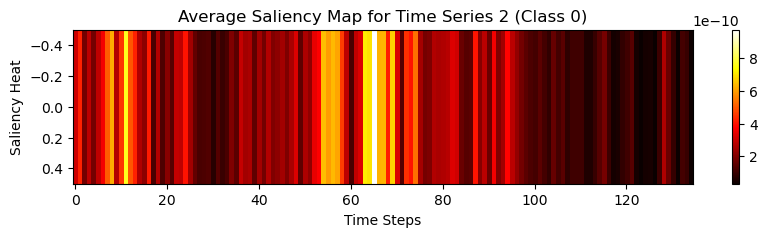

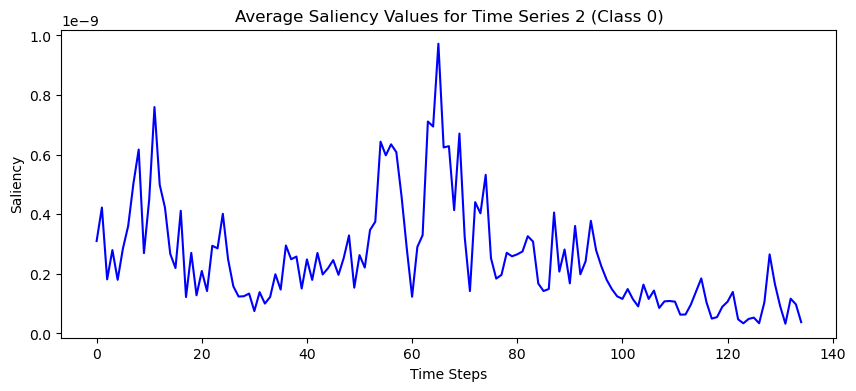

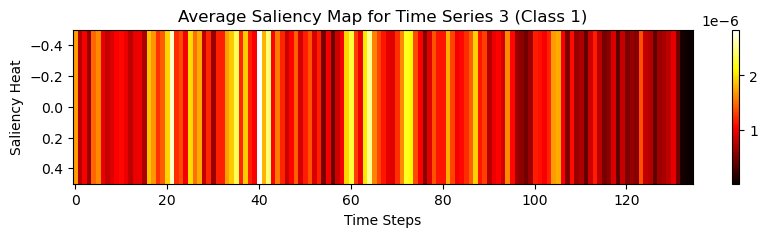

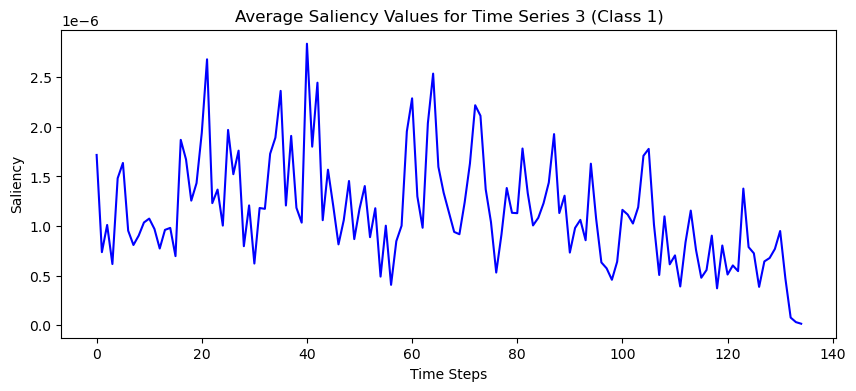

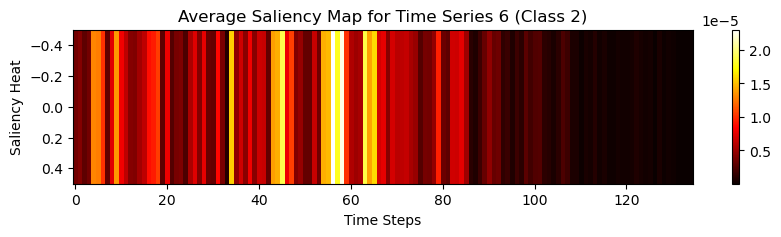

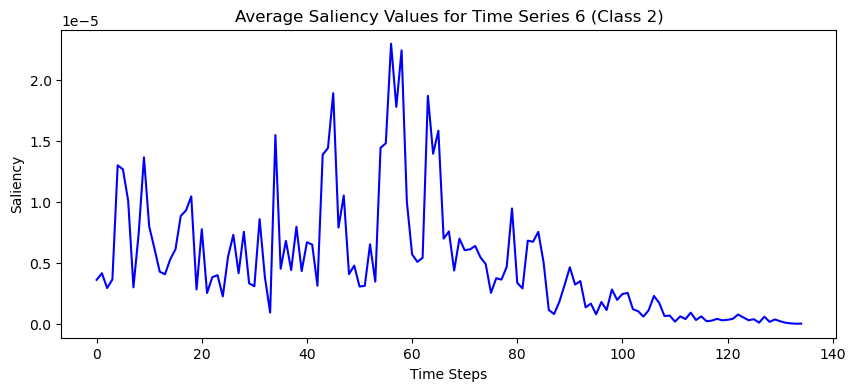

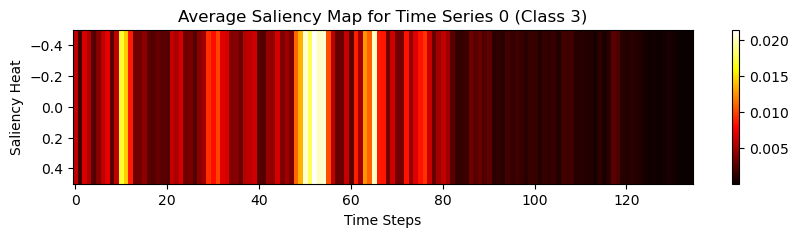

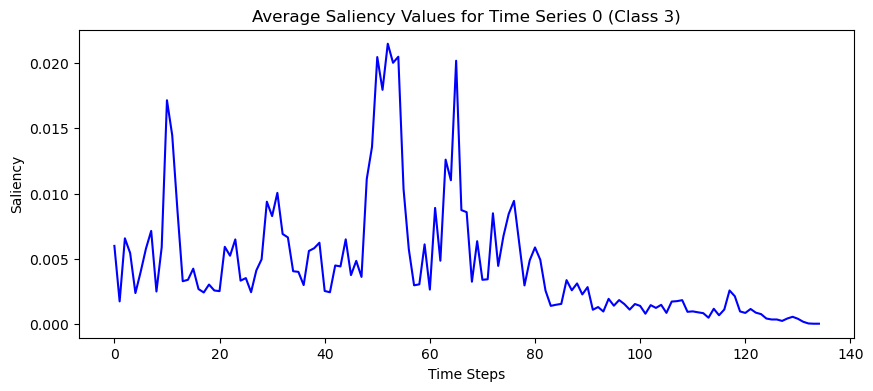

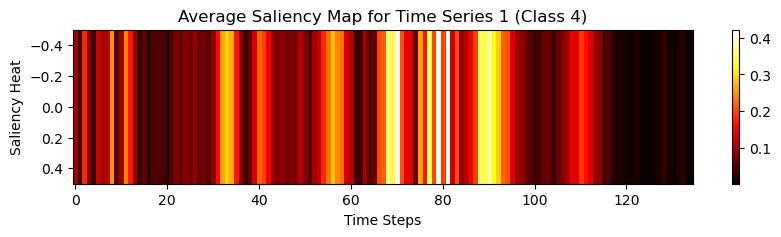

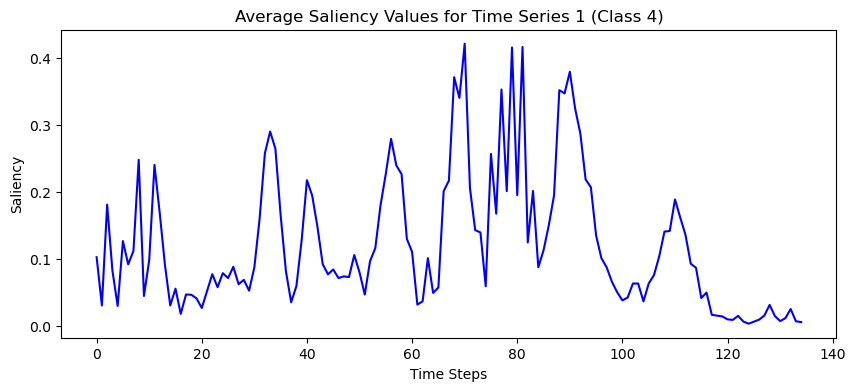

In [9]:
def mc_dropout_predict(model, X_test, test_ids, num_samples=100):
    """
    Peforms Monte Carlo dropout, where dropout is applied at inference time. 
    This takes as input the trained ForeClassNet model, the input observed time series, 
    the id's associated with the time series in the test set, and the number of MC samples which
    is the number of forward passes through the trained ForeClassNet model. 
    """
    forecast_predictions = [] #list to store the forecast output from each forward pass through ForeClassNet
    classification_predictions = [] #list to store the classification output from each forwards pass through ForeClassNet
    for _ in tqdm(range(num_samples), desc="MC Dropout passes"):
        forecast, classification = model.predict([X_test, test_ids], verbose=0) #performs a forward pass through the network 
        forecast_predictions.append(forecast) #add the forecats array to the list 
        classification_predictions.append(classification) #add the classification array of probabilities to the list
    forecast_predictions = np.array(forecast_predictions)
    classification_predictions = np.array(classification_predictions) 
    mean_forecast = np.mean(forecast_predictions, axis=0) #take the mean with respect to the MC samples of the forecast output
    std_forecast = np.std(forecast_predictions, axis=0) #take the standard deviation with respect to the MC samples of the forecast output
    mean_classification = np.mean(classification_predictions, axis=0) #take the mean with respect to the MC samples of the classification probabilities
    std_classification = np.std(classification_predictions, axis=0) #take the standard deviation with respect to the MC samples of the classification probabilities
    return (mean_forecast, std_forecast), (mean_classification, std_classification)
n_test_series = X_observed_test.shape[0]
test_series_ids = np.arange(n_test_series, dtype=np.int32)
welford_forecast_layer = model.get_layer("Welford") 
welford_forecast_layer.reset_statistics() #reset the statistics in the Welford layer
(mean_forecast, forecast_uncertainty), (mean_classification, classification_uncertainty) = mc_dropout_predict(
    model,X_observed_test,    test_series_ids,    num_samples=100)
predicted_classes = np.argmax(mean_classification, axis=-1) #obtain the predicted classess 
def compute_average_saliency_map(model, input_series, series_ids, target_class_idx, num_samples=100):
    input_series_tf = tf.convert_to_tensor(input_series, dtype=tf.float32)
    series_ids_tf   = tf.convert_to_tensor(series_ids, dtype=tf.int32)
    saliency_maps = []
    for _ in range(num_samples):
        with tf.GradientTape() as tape:
            tape.watch(input_series_tf)
            forecasts, predictions = model([input_series_tf, series_ids_tf])
            target_class_value = predictions[0, target_class_idx]
        grads = tape.gradient(target_class_value, input_series_tf)
        saliency_maps.append(tf.abs(grads))
    avg_saliency = tf.reduce_mean(tf.stack(saliency_maps, axis=0), axis=0)
    return avg_saliency.numpy()
true_labels = np.argmax(y_test, axis=1)
for c in range(n_classes):
    indices = np.where((true_labels == c) & (predicted_classes == c))[0]
    idx = indices[0]
    avg_saliency_map = compute_average_saliency_map(
        model,
        X_observed_test[idx:idx+1],
        [test_series_ids[idx]],
        c,
        num_samples=100
    )
    plt.figure(figsize=(10, 2))
    plt.imshow(avg_saliency_map.squeeze()[None, :], cmap='hot', aspect='auto')
    plt.title(f'Average Saliency Map for Time Series {idx} (Class {c})')
    plt.xlabel('Time Steps')
    plt.ylabel('Saliency Heat')
    plt.colorbar()
    plt.show()
    plt.figure(figsize=(10, 4))
    plt.plot(avg_saliency_map.squeeze(), color='blue')
    plt.title(f'Average Saliency Values for Time Series {idx} (Class {c})')
    plt.xlabel('Time Steps')
    plt.ylabel('Saliency')
    plt.savefig(f'ECG_saliency_lineplot_class_{c}_idx_{idx}.png', dpi=300, bbox_inches='tight')
    plt.show()


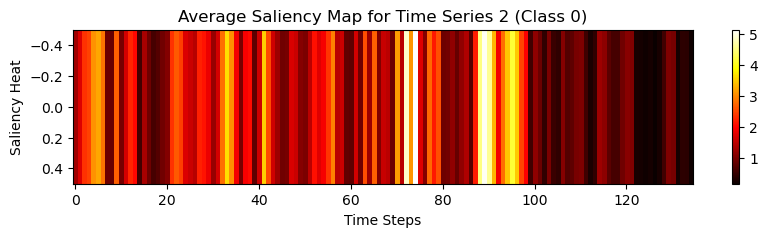

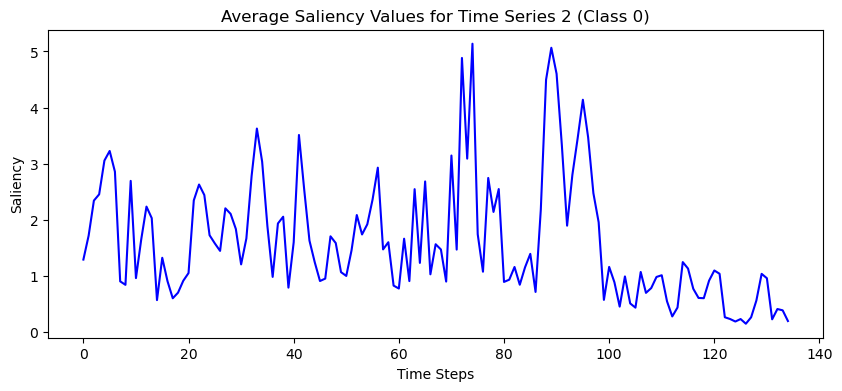

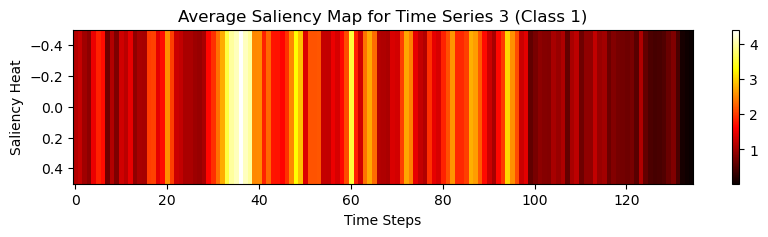

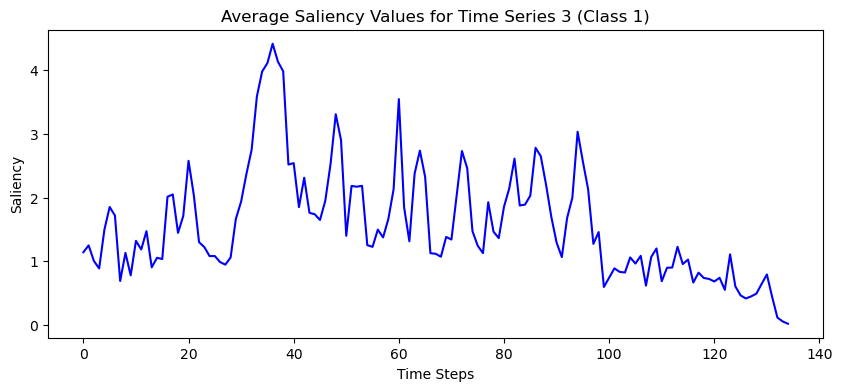

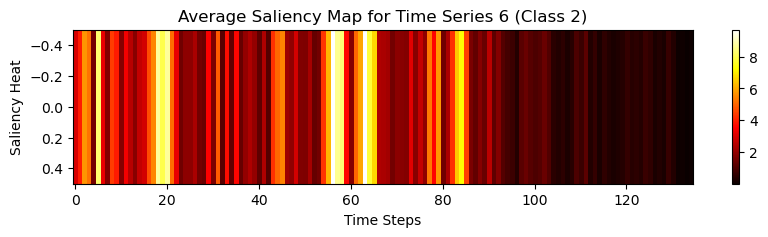

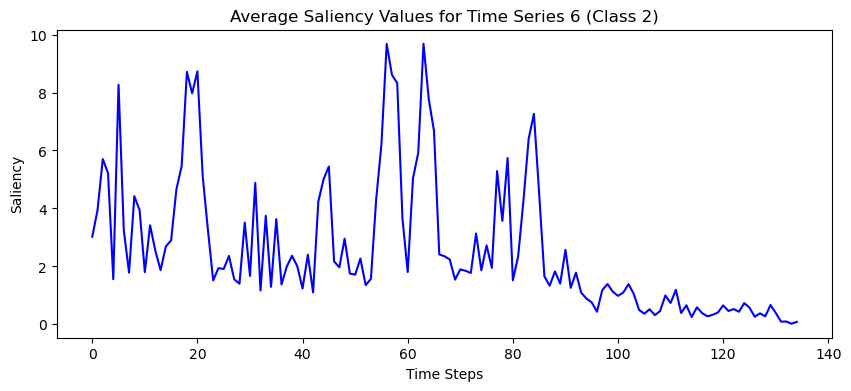

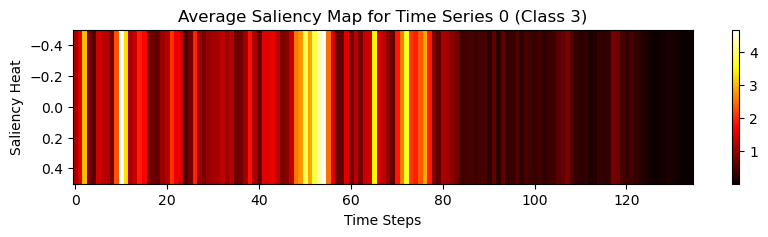

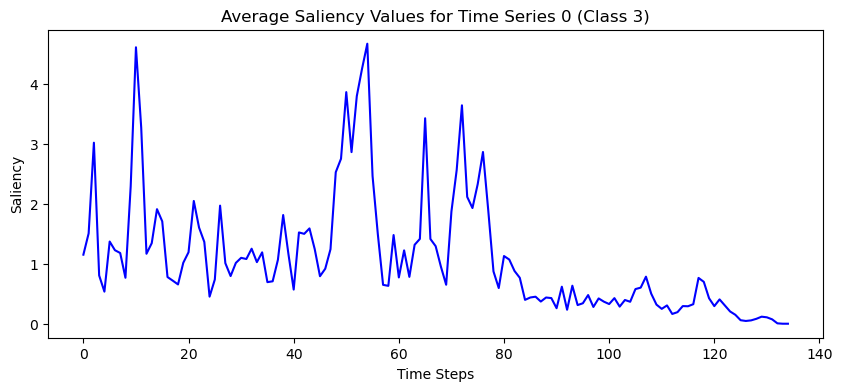

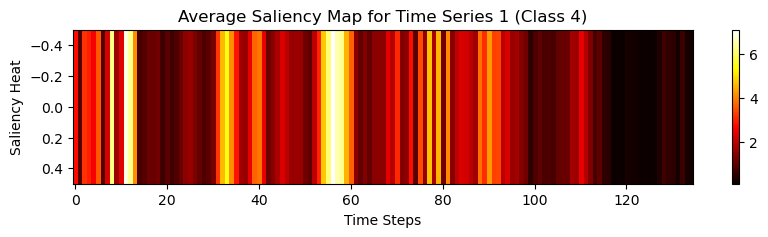

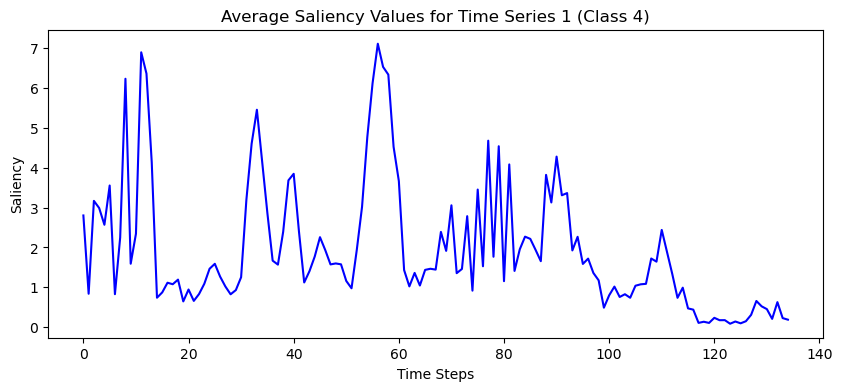

In [12]:
def compute_average_saliency_map(model, input_series, series_ids, target_class_idx, num_samples=100):
    input_series_tf = tf.convert_to_tensor(input_series, dtype=tf.float32)
    series_ids_tf   = tf.convert_to_tensor(series_ids, dtype=tf.int32)
    saliency_maps = []
    logits = tf.keras.Model(inputs=model.inputs,outputs=model.get_layer("classification_output").output)
    for _ in range(num_samples):
        with tf.GradientTape() as tape:
            tape.watch(input_series_tf)
            predictions = logits([input_series_tf, series_ids_tf])
            target_class_value = predictions[0, target_class_idx]
        grads = tape.gradient(target_class_value, input_series_tf)
        saliency_maps.append(tf.abs(grads))
    avg_saliency = tf.reduce_mean(tf.stack(saliency_maps, axis=0), axis=0)
    return avg_saliency.numpy()
true_labels = np.argmax(y_test, axis=1)
for c in range(n_classes):
    indices = np.where((true_labels == c) & (predicted_classes == c))[0]
    idx = indices[0]
    avg_saliency_map = compute_average_saliency_map(
        model,
        X_observed_test[idx:idx+1],
        [test_series_ids[idx]],
        c,
        num_samples=100
    )
    plt.figure(figsize=(10, 2))
    plt.imshow(avg_saliency_map.squeeze()[None, :], cmap='hot', aspect='auto')
    plt.title(f'Average Saliency Map for Time Series {idx} (Class {c})')
    plt.xlabel('Time Steps')
    plt.ylabel('Saliency Heat')
    plt.colorbar()
    plt.show()
    plt.figure(figsize=(10, 4))
    plt.plot(avg_saliency_map.squeeze(), color='blue')
    plt.title(f'Average Saliency Values for Time Series {idx} (Class {c})')
    plt.xlabel('Time Steps')
    plt.ylabel('Saliency')
    plt.savefig(f'ECG_saliency_lineplot_class_{c}_idx_{idx}.png', dpi=300, bbox_inches='tight')
    plt.show()